In [1]:
# 0) Instalar dependencias (solo una vez por sesión)
!pip -q install imbalanced-learn xgboost lightgbm catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.0 MB/s eta 0:00:00


In [10]:
# =========================================
# ML completo — Dataset Diabetes (adaptado paso a paso)
# =========================================
import os, json, warnings, platform, datetime, shutil, glob, tempfile
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [22]:
# Subir archivo desde tu laptop a Colab
from google.colab import files
uploaded = files.upload()   # aparecerá un botón para elegir el archivo

# Verifica el nombre exacto que se subió
import os
print(list(uploaded.keys()))


Saving dataset_diabetes.csv to dataset_diabetes (1).csv
['dataset_diabetes (1).csv']


In [24]:
# =========================================
# SUBIR CSV DESDE TU LAPTOP + CARGAR Y BINARIZAR TARGET 'Diabetes_012'
# (maneja strings como 'no diabetes', 'prediabetes', etc.)
# =========================================
from google.colab import files
import pandas as pd
import numpy as np
import csv

# 1) Subir archivo
uploaded = files.upload()  # elige tu CSV
DATA_FILE = list(uploaded.keys())[0]
print("Archivo subido:", DATA_FILE)

# 2) Lectura robusta (auto-detector de separador y skip de líneas malas)
def read_csv_robust(path):
    try:
        with open(path, 'r', encoding='utf-8', newline='') as fh:
            sample = fh.read(20480)
            fh.seek(0)
            try:
                dialect = csv.Sniffer().sniff(sample, delimiters=[',',';','\t','|'])
                sep = dialect.delimiter
            except Exception:
                sep = ','
        return pd.read_csv(path, engine='python', sep=sep, on_bad_lines='skip')
    except Exception:
        # fallbacks
        for sep in [';', '\t', ',']:
            try:
                return pd.read_csv(path, engine='python', sep=sep, on_bad_lines='skip')
            except Exception:
                pass
        raise

df = read_csv_robust(DATA_FILE)

# 3) Target binario: Diabetes_012 -> 0 (no) / 1 (sí: 1 o 2)
TARGET = "Diabetes_012"
assert TARGET in df.columns, f"No existe la columna '{TARGET}'. Columnas: {df.columns.tolist()}"

col = df[TARGET].astype(str).str.strip().str.lower()

pos = {"1","2","sí","si","yes","true","pos","positivo","diabetes","prediabetes","pre-diabetes","pre diabetes"}
neg = {"0","no","false","neg","negativo","no diabetes","none","nan"}

def to01(x):
    if x in pos: return 1
    if x in neg: return 0
    try:
        return int(float(x) >= 1.0)
    except:
        return np.nan

y = col.map(to01).astype('float')
mask = ~y.isna()
if (~mask).sum() > 0:
    print(f"Filas descartadas por label desconocido: {(~mask).sum()}")
df = df.loc[mask].reset_index(drop=True)
y = y.loc[mask].astype(int).reset_index(drop=True)

X = df.drop(columns=[TARGET])

print("Shape X:", X.shape, "| Prevalencia(1):", float((y==1).mean()))
print("Clases originales (muestra):", col.unique()[:6])
print("Primeras columnas de X:", X.columns.tolist()[:10])


Saving dataset_diabetes.csv to dataset_diabetes (2).csv
Archivo subido: dataset_diabetes (2).csv
Shape X: (253680, 21) | Prevalencia(1): 0.15758830022075054
Clases originales (muestra): ['no diabetes' 'diabetes' 'prediabetes']
Primeras columnas de X: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies']


In [11]:
# =========================================
# 2) Split temprano (80/20)
# =========================================
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print(f"Train: {X_train.shape} | Test: {X_test.shape}")


Train: (202944, 21) | Test: (50736, 21)


In [16]:
# =========================================
# 3) Preprocesamiento con IMPUTACIÓN (fix NaN) + OHE + Escalado + SMOTE
# Sustituye tu paso 3 por ESTE
# =========================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

cat_features = X_train.select_dtypes(include=["object","category","string"]).columns.tolist()
num_features = X_train.select_dtypes(include=["number","bool"]).columns.tolist()

# Pipelines internos para ColumnTransformer
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = SkPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = SkPipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, cat_features),
    ]
)

smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)

def build_pipe(model):
    return ImbPipeline([("prep", preprocessor), ("smote", smote), ("model", model)])


In [13]:
# =========================================
# 4) Modelos candidatos
# =========================================
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None
try:
    from lightgbm import LGBMClassifier
except Exception:
    LGBMClassifier = None
try:
    from catboost import CatBoostClassifier
except Exception:
    CatBoostClassifier = None

candidates = [
    ("LRN", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    ("LDA", LinearDiscriminantAnalysis()),
    ("KNN", KNeighborsClassifier()),
    ("GNB", GaussianNB()),
    ("DTS", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ("RFS", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)),
    ("NNM", MLPClassifier(hidden_layer_sizes=(64,), max_iter=600, random_state=RANDOM_STATE)),
]
if XGBClassifier is not None:
    candidates.append(("XGB", XGBClassifier(
        tree_method="hist", eval_metric="logloss", random_state=RANDOM_STATE,
        n_estimators=400, learning_rate=0.05, max_depth=6,
        subsample=0.9, colsample_bytree=0.9, n_jobs=-1
    )))
if LGBMClassifier is not None:
    candidates.append(("LGB", LGBMClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=-1,
        subsample=0.9, colsample_bytree=0.9,
        random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1
    )))
if CatBoostClassifier is not None:
    candidates.append(("CAT", CatBoostClassifier(
        iterations=600, learning_rate=0.05, depth=6,
        random_state=RANDOM_STATE, l2_leaf_reg=3.0,
        verbose=False, allow_writing_files=False, thread_count=-1
    )))

In [17]:
# =========================================
# 5) Entrenar Baseline con CV (sin tuning) — vuelve a ejecutar con el preprocesamiento nuevo
# =========================================
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"accuracy":"accuracy", "f1_macro":"f1_macro", "roc_auc":"roc_auc"}

baseline_rows = []
for name, model in candidates:
    pipe = build_pipe(model)
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    baseline_rows.append({
        "model":name,
        "acc_mean":scores["test_accuracy"].mean(),
        "acc_std" :scores["test_accuracy"].std(),
        "f1_mean" :scores["test_f1_macro"].mean(),
        "f1_std"  :scores["test_f1_macro"].std(),
        "auc_mean":scores["test_roc_auc"].mean(),
    })
    print(f"{name:>4} | ACC {scores['test_accuracy'].mean():.3f} "
          f"| F1 {scores['test_f1_macro'].mean():.3f} | AUC {scores['test_roc_auc'].mean():.3f}")

baseline_df = pd.DataFrame(baseline_rows).sort_values("f1_mean", ascending=False)
from IPython.display import display
display(baseline_df)

baseline_best_name  = baseline_df.iloc[0]["model"]
baseline_best_model = dict(candidates)[baseline_best_name]
print(f">>> Baseline ganador: {baseline_best_name}")


 LRN | ACC 0.729 | F1 0.644 | AUC 0.817
 LDA | ACC 0.722 | F1 0.640 | AUC 0.817
 KNN | ACC 0.708 | F1 0.603 | AUC 0.721
 GNB | ACC 0.724 | F1 0.631 | AUC 0.781
 DTS | ACC 0.776 | F1 0.596 | AUC 0.600
 RFS | ACC 0.835 | F1 0.636 | AUC 0.795
 NNM | ACC 0.755 | F1 0.648 | AUC 0.795
 XGB | ACC 0.850 | F1 0.627 | AUC 0.822
 LGB | ACC 0.851 | F1 0.624 | AUC 0.823
 CAT | ACC 0.851 | F1 0.619 | AUC 0.825


,model,acc_mean,acc_std,f1_mean,f1_std,auc_mean
6,NNM,0.755110,0.007489,0.648326,0.004508,0.795027
0,LRN,0.729364,0.001058,0.643867,0.001690,0.817051
1,LDA,0.722485,0.000517,0.639523,0.000970,0.816530
5,RFS,0.834580,0.001059,0.636187,0.003467,0.794668
3,GNB,0.723998,0.001378,0.630560,0.002215,0.781199
7,XGB,0.849899,0.001118,0.626958,0.003528,0.822316
8,LGB,0.851023,0.001476,0.624414,0.004625,0.823317
9,CAT,0.850993,0.001389,0.619365,0.004043,0.824566
2,KNN,0.708299,0.001029,0.603140,0.000967,0.720737
4,DTS,0.775588,0.001620,0.595919,0.003855,0.599714


>>> Baseline ganador: NNM


In [18]:
# =========================================
# 6) Tuning con CV y elección del ganador
# =========================================
import tempfile, shutil
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
try:
    from scipy.stats import loguniform
except:
    from sklearn.utils.fixes import loguniform

cv_light = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_heavy = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

param_spaces = {
    "NNM": {
        "model__hidden_layer_sizes":[(32,), (64,), (128,), (64,32)],
        "model__activation":["relu","tanh"],
        "model__alpha":loguniform(1e-4, 1e-1),
        "model__learning_rate_init":loguniform(1e-4, 1e-2),
        "model__max_iter":[400,600,800]
    },
    "LRN":{"model__C":loguniform(1e-2,1e1),"model__penalty":["l2"],
           "model__solver":["lbfgs","liblinear"],"model__class_weight":[None,"balanced"]},
    "RFS":{"model__n_estimators":randint(200,500),"model__max_depth":randint(4,14),
           "model__min_samples_split":randint(2,16),"model__min_samples_leaf":randint(1,8),
           "model__max_features":["sqrt","log2",None],"model__bootstrap":[True,False]},
    "XGB":{"model__n_estimators":randint(250,600),"model__learning_rate":loguniform(5e-3,2e-1),
           "model__max_depth":randint(3,9),"model__subsample":uniform(0.7,0.3),
           "model__colsample_bytree":uniform(0.7,0.3),"model__min_child_weight":randint(1,6)},
    "LGB":{"model__n_estimators":randint(300,800),"model__learning_rate":loguniform(5e-3,2e-1),
           "model__num_leaves":randint(16,128),"model__max_depth":randint(-1,12),
           "model__min_child_samples":randint(10,50),"model__subsample":uniform(0.7,0.3),
           "model__colsample_bytree":uniform(0.7,0.3),"model__reg_lambda":loguniform(1e-3,10)},
    "CAT":{"model__iterations":randint(300,700),"model__learning_rate":loguniform(5e-3,2e-1),
           "model__depth":randint(4,10),"model__l2_leaf_reg":loguniform(1e-2,30),
           "model__border_count":randint(32,255)},
}

to_tune = [
    ("NNM", MLPClassifier(random_state=RANDOM_STATE, max_iter=600)),
    ("LRN", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    ("RFS", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=1)),
    ("XGB", XGBClassifier(tree_method="hist", eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=1)),
    ("LGB", LGBMClassifier(random_state=RANDOM_STATE, n_jobs=1, verbosity=-1)),
    ("CAT", CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, allow_writing_files=False, thread_count=1)),
]

refit_metric = "f1_macro"
scoring_opt = {"f1_macro":"f1_macro", "roc_auc":"roc_auc", "accuracy":"accuracy"}

best_models = []
cache_dir = tempfile.mkdtemp(prefix="skcache_")

try:
    for name, base_model in to_tune:
        pipe = build_pipe(base_model)
        heavy = name in ["XGB","LGB","CAT","NNM"]
        search = RandomizedSearchCV(
            pipe, param_spaces[name],
            n_iter=(10 if heavy else 7), # menos iteraciones para que no tarde tanto
            cv=(cv_heavy if heavy else cv_light),
            scoring=scoring_opt, refit=refit_metric,
            n_jobs=-1, random_state=RANDOM_STATE, verbose=1
        )
        search.fit(X_train, y_train)
        best_models.append((name, search.best_estimator_, search.best_score_, search.best_params_))
finally:
    shutil.rmtree(cache_dir, ignore_errors=True)

best_models.sort(key=lambda x: (x[2] if pd.notna(x[2]) else -1), reverse=True)
best_name, winner_pipe, best_cv_f1, best_params = best_models[0]

print(f">>> GANADOR OPTIMIZADO: {best_name} (F1 CV={best_cv_f1:.4f})")
print("Mejores hiperparámetros:", best_params)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
>>> GANADOR OPTIMIZADO: XGB (F1 CV=0.6814)
Mejores hiperparámetros: {'model__colsample_bytree': np.float64(0.7467983561008608), 'model__learning_rate': np.float64(0.006194745024628934), 'model__max_depth': 7, 'model__min_child_weight': 4, 'model__n_estimators': 401, 'model__subsample': np.float64(0.8952665418846558)}


Train: (202944, 21) | Test: (50736, 21)

== Reporte en TEST ==
              precision    recall  f1-score   support

           0     0.9114    0.8571    0.8834     42741
           1     0.4206    0.5546    0.4784      7995

    accuracy                         0.8094     50736
   macro avg     0.6660    0.7059    0.6809     50736
weighted avg     0.8341    0.8094    0.8196     50736

Matriz de confusión:
 [[36634  6107]
 [ 3561  4434]]
ROC-AUC: 0.8172194874083334
PR-AUC : 0.4470444214626439


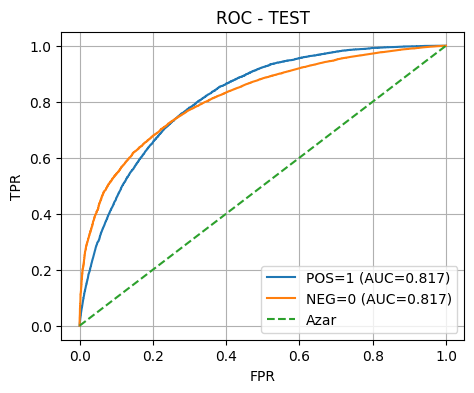

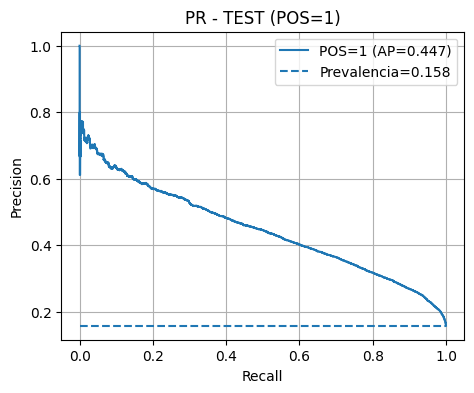

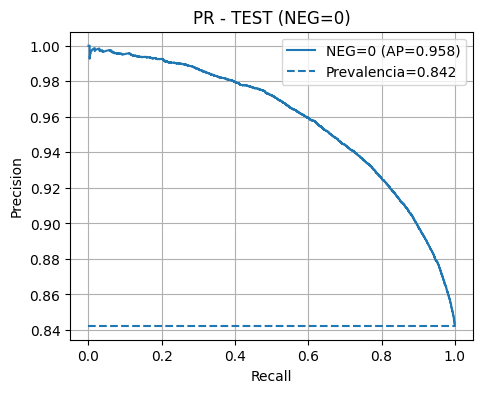

In [25]:
# =========================================
# SPLIT + PREPROCESAMIENTO + RECONSTRUIR XGB GANADOR + EVALUACIÓN TEST
# (celda autosuficiente; asume que ya tienes X, y del paso de carga)
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score,
                             roc_curve, auc, precision_recall_curve)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# ---------- 1) Split ----------
RANDOM_STATE = 42
BEST_THR = 0.50
winner_name = "XGB"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print(f"Train: {X_train.shape} | Test: {X_test.shape}")

# ---------- 2) Preprocesamiento (imputer + scaler + OHE) + SMOTE ----------
cat_features = X_train.select_dtypes(include=["object","category","string"]).columns.tolist()
num_features = X_train.select_dtypes(include=["number","bool"]).columns.tolist()

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = SkPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = SkPipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_features),
    ("cat", cat_pipe, cat_features),
])

smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)

def build_pipe(model):
    return ImbPipeline([("prep", preprocessor), ("smote", smote), ("model", model)])

# ---------- 3) Reconstruir XGB con hiperparámetros ganadores ----------
best_params = {
    "model__colsample_bytree": 0.7467983561008608,
    "model__learning_rate":    0.006194745024628934,
    "model__max_depth":        7,
    "model__min_child_weight": 4,
    "model__n_estimators":     401,
    "model__subsample":        0.8952665418846558,
}

base_xgb = XGBClassifier(
    tree_method="hist", eval_metric="logloss",
    random_state=RANDOM_STATE, n_jobs=-1
)
winner_pipe = build_pipe(base_xgb)
winner_pipe.set_params(**best_params)

# ---------- 4) Entrenar y evaluar en TEST ----------
winner_pipe.fit(X_train, y_train)
proba_test = winner_pipe.predict_proba(X_test)[:, 1]
y_pred     = (proba_test >= BEST_THR).astype(int)

print("\n== Reporte en TEST ==")
print(classification_report(y_test, y_pred, digits=4))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, proba_test))
print("PR-AUC :", average_precision_score(y_test, proba_test))

# ---------- 5) Curvas ROC y PR ----------
proba = winner_pipe.predict_proba(X_test)
proba1 = proba[:, 1]
proba0 = proba[:, 0]
y_true = np.asarray(y_test)
y_true0 = 1 - y_true

# ROC
fpr1, tpr1, _ = roc_curve(y_true, proba1);  roc_auc1 = auc(fpr1, tpr1)
fpr0, tpr0, _ = roc_curve(y_true0, proba0); roc_auc0 = auc(fpr0, tpr0)

plt.figure(figsize=(5.2, 4))
plt.plot(fpr1, tpr1, label=f"POS=1 (AUC={roc_auc1:.3f})")
plt.plot(fpr0, tpr0, label=f"NEG=0 (AUC={roc_auc0:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Azar")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC - TEST")
plt.legend(); plt.grid(True); plt.show()

# PR clase 1
prec1, rec1, _ = precision_recall_curve(y_true, proba1)
ap1   = average_precision_score(y_true, proba1)
prev1 = y_true.mean()

plt.figure(figsize=(5.2, 4))
plt.step(rec1, prec1, where="post", label=f"POS=1 (AP={ap1:.3f})")
plt.hlines(prev1, 0, 1, linestyles="--", label=f"Prevalencia={prev1:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR - TEST (POS=1)")
plt.legend(); plt.grid(True); plt.show()

# PR clase 0
prec0, rec0, _ = precision_recall_curve(y_true0, proba0)
ap0   = average_precision_score(y_true0, proba0)
prev0 = y_true0.mean()

plt.figure(figsize=(5.2, 4))
plt.step(rec0, prec0, where="post", label=f"NEG=0 (AP={ap0:.3f})")
plt.hlines(prev0, 0, 1, linestyles="--", label=f"Prevalencia={prev0:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR - TEST (NEG=0)")
plt.legend(); plt.grid(True); plt.show()


El modelo entrenado muestra un desempeño global adecuado, con una precisión general del **81%** y un **ROC-AUC de 0.82**, lo que indica una buena capacidad de discriminación entre personas con y sin diabetes/prediabetes. En la clase negativa (no diabetes) el modelo presenta resultados sólidos (precisión del 91% y recall del 86%), lo que lo hace confiable para descartar casos. Sin embargo, en la clase positiva (diabetes/prediabetes) su desempeño es moderado (precisión del 42% y recall del 55%), evidenciando que aún se pierden casos positivos y se generan falsos positivos. En conclusión, el modelo es útil como herramienta de apoyo inicial para identificar factores de riesgo, pero requiere ajustes (como la optimización del umbral de decisión) para mejorar la detección de casos positivos sin comprometer en exceso la precisión.
